<a href="https://colab.research.google.com/github/alcalderagl/self_driving_car/blob/main/ConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Master of Applied Artificial Intelligence

**Course: TC4033 - Autonomous Driving**

<img src="https://github.com/alcalderagl/self_driving_car/blob/main/images/logo.png?raw=1" alt="TEC DE MONTERREY" width="500"/>

**CONV. NEURAL NETWORKS**

Tutor: Dr. David Antonio Torres


Team members:
* Rafael Bernando Orozco Palma - A01795359
* Arantxa Stephania Coronel González - A01620352
* Alejandro Calderon Aguilar - A01795353

In [32]:
!git clone https://github.com/alcalderagl/self_driving_car.git

Cloning into 'self_driving_car'...
remote: Enumerating objects: 2204, done.
remote: Counting objects: 100% (2204/2204), done.
remote: Compressing objects: 100% (2181/2181), done.
remote: Total 2204 (delta 56), reused 2137 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (2204/2204), 18.15 MiB | 34.29 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [33]:
%cd /content/self_driving_car
!ls

/content/self_driving_car
ConvNN.ipynb  data  images  notebooks  README.md  self_driving_car  src


# Import libraries

In [34]:
# Librerías para visualización y manejo de datos
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Librería para descargar datasets desde KaggleHub (acceso simplificado a Kaggle)
import kagglehub

# Librerías para procesamiento de imágenes
from PIL import Image
import os
import cv2

# TensorFlow y Keras para definir y entrenar redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Añadir ruta al sistema para poder importar módulos personalizados (utils.py en una ruta específica)
import sys
sys.path.append('/content/self_driving_car/src/utils')
from utils import Utils

# GPU on

In [35]:
# Imprime la lista de dispositivos GPU disponibles en el entorno actual
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Global variables

In [36]:
nrows = 5          # Filas para mostrar imágenes
ncols = 2          # Columnas para mostrar imágenes
figsize = (12, 18) # Tamaño de la figura en pulgadas

utils = Utils()    # Instancia de la clase Utils

# Import dataset

In [37]:
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")  # Descarga el dataset desde KaggleHub
print(path)  # Muestra la ruta local donde se guardó el dataset

/kaggle/input/gtsrb-german-traffic-sign


# Load Train dataset

In [38]:
train_df = pd.read_csv(path + "/Train.csv")  # Carga el archivo CSV de entrenamiento como DataFrame
train_df.head()  # Muestra las primeras 5 filas del DataFrame

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [39]:
# Estadísticas descriptivas transpuestas del DataFrame
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Width,39209.0,50.835880,24.306933,25.0,35.0,43.0,58.0,243.0
Height,39209.0,50.328930,23.115423,25.0,35.0,43.0,58.0,225.0
Roi.X1,39209.0,5.999515,1.475493,0.0,5.0,6.0,6.0,20.0
Roi.Y1,39209.0,5.962381,1.385440,5.0,5.0,6.0,6.0,20.0
Roi.X2,39209.0,45.197302,23.060157,20.0,29.0,38.0,53.0,223.0
Roi.Y2,39209.0,44.728379,21.971145,20.0,30.0,38.0,52.0,205.0
ClassId,39209.0,15.788390,12.013238,0.0,5.0,12.0,25.0,42.0


**Interpretación de resultados**
* Las imágenes tienen dimensiones variadas, por eso se deben redimensionar (a 32×32 px).

* Las regiones de interés (Roi) marcan dónde está la señal, pero no son necesarias si se usa toda la imagen.

* Las clases están representadas por valores enteros, y se deben codificar para entrenamiento.

* ID de clase (0 a 42)

## Plot class distribution

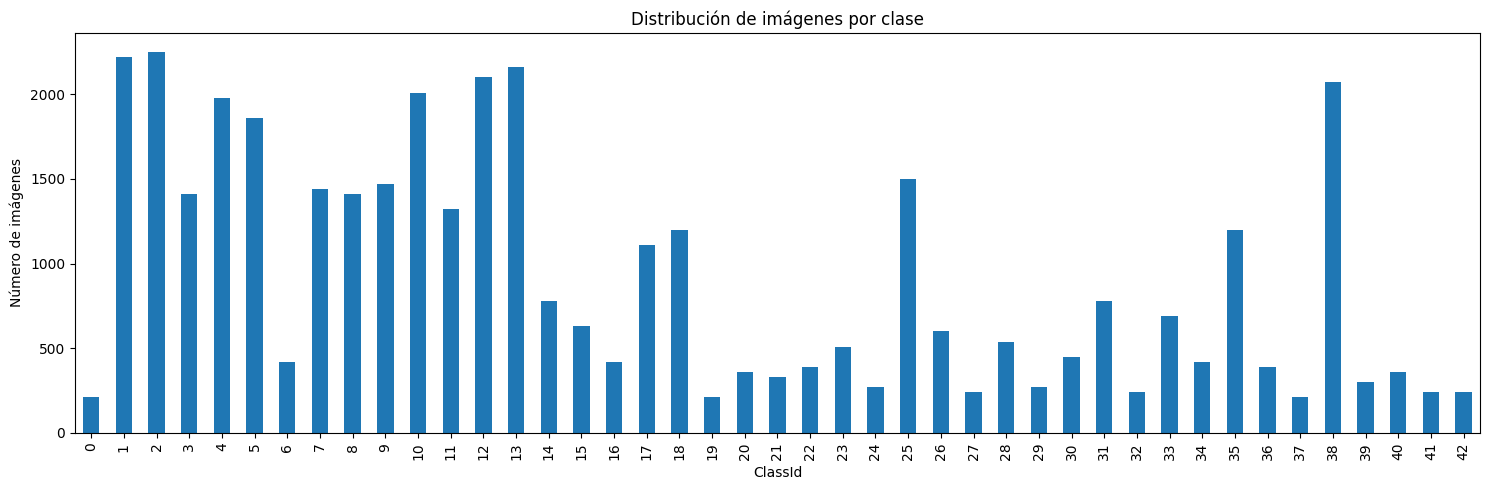

In [40]:
# Grafica la cantidad de imágenes por clase (distribución de clases)
train_df['ClassId'].value_counts().sort_index().plot(kind="bar", figsize=(15, 5), title="Distribución de imágenes por clase")
plt.xlabel("ClassId")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Interpretación de resultados**

La gráfica muestra un claro desbalance en la cantidad de imágenes por clase del dataset GTSRB. Algunas clases tienen más de 2000 ejemplos, mientras que otras tienen menos de 500, lo cual puede afectar la precisión del modelo en clases poco representadas.

## Get classes

In [41]:
classes = np.sort(train_df['ClassId'].unique())  # Clases únicas ordenadas
print(classes)  # Muestra del 0 al 42 en orden

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


## Plot class images

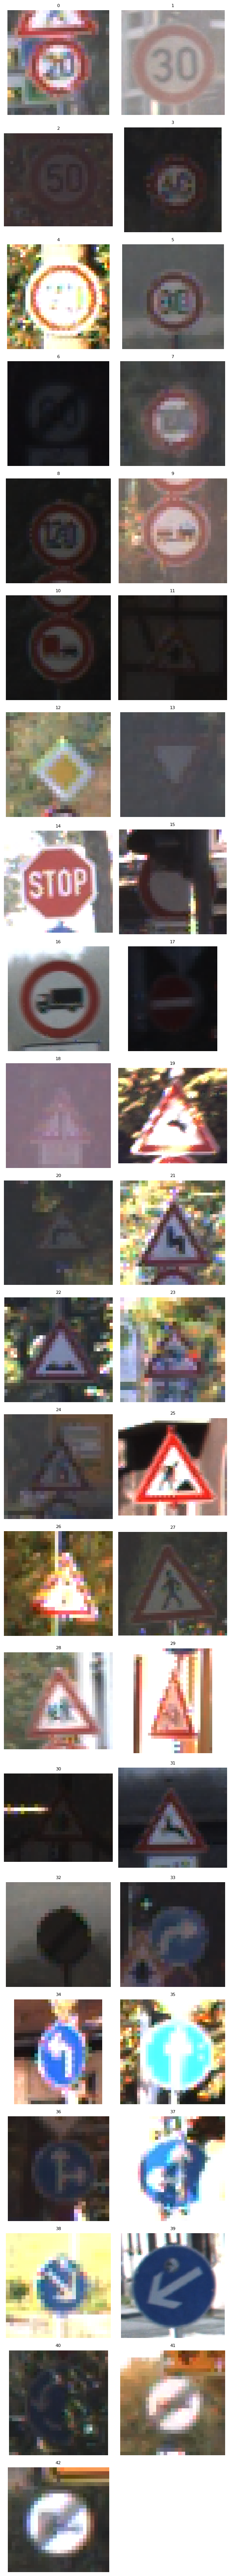

In [42]:
# Selecciona la primera imagen de cada clase
samples = train_df.groupby('ClassId').first().reset_index()

# Listas para almacenar imágenes y sus etiquetas
sample_imgs = []
sample_labels = []

# Número total de clases (43 en GTSRB)
n_samples = len(samples)

# Itera sobre cada clase y carga su imagen representativa
for _, row in samples.iterrows():
    image = Image.open(f"{path}/{row['Path']}")  # Abre la imagen desde su ruta
    sample_labels.append(row['ClassId'])         # Guarda el ID de la clase
    sample_imgs.append(image)                    # Guarda la imagen

# Muestra una imagen por clase en una cuadrícula vertical
utils.plot_images(images=sample_imgs, labels=sample_labels, nrows=round(n_samples/2), ncols=ncols, figsize=(6,66))


**Descripción de código**

Este bloque carga el dataset de entrenamiento GTSRB desde Train.csv, muestra estadísticas para entender la cantidad y variedad de datos, grafica la distribución de imágenes por clase (0 a 42) y visualiza una imagen representativa por clase. Esto permite detectar clases desbalanceadas y conocer visualmente las señales que el modelo debe aprender a clasificar.

# Load Test dataset

In [43]:
test_df = pd.read_csv(path + "/Test.csv")  # Carga el archivo CSV de prueba como DataFrame
test_df.head()  # Muestra las primeras 5 filas del conjunto de prueba

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [44]:
# Estadísticas descriptivas transpuestas del DataFrame de prueba
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Width,12630.0,50.507759,25.088483,25.0,34.0,43.0,58.0,266.0
Height,12630.0,50.364450,23.698908,25.0,35.0,43.0,57.0,232.0
Roi.X1,12630.0,5.998021,1.543954,1.0,5.0,6.0,6.0,23.0
Roi.Y1,12630.0,5.982423,1.427424,5.0,5.0,6.0,6.0,19.0
Roi.X2,12630.0,44.864450,23.776102,20.0,29.0,38.0,53.0,244.0
Roi.Y2,12630.0,44.758116,22.494697,20.0,29.0,38.0,52.0,212.0
ClassId,12630.0,15.551069,11.947123,0.0,5.0,12.0,25.0,42.0


**Interpretación de resultados**

La tabla muestra que las imágenes del conjunto de prueba tienen tamaños promedio de ~50×50 px, con variación moderada. Las coordenadas ROI indican que las señales están centradas. Hay 43 clases (0 a 42), con distribución similar al conjunto de entrenamiento, , lo cual es ideal para una evaluación coherente del modelo.

## Plot class distribution

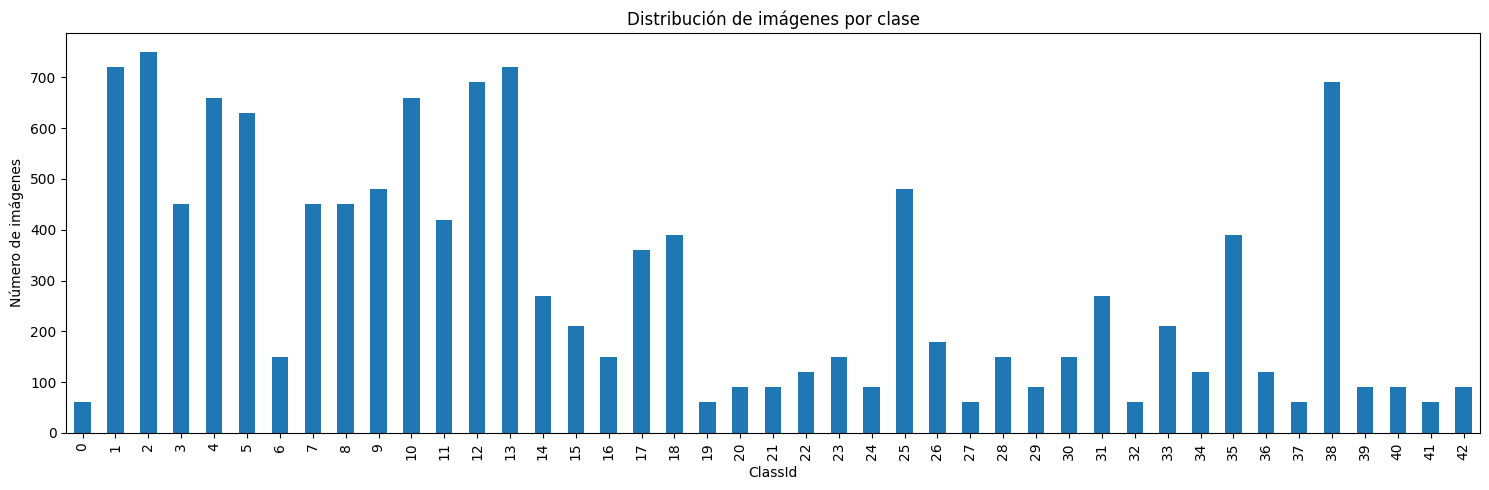

In [45]:
# Grafica la cantidad de imágenes por clase (distribución de clases)
test_df['ClassId'].value_counts().sort_index().plot(kind="bar", figsize=(15, 5), title="Distribución de imágenes por clase")
plt.xlabel("ClassId")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Interpretación de resultados**

La gráfica muestra la distribución de imágenes por clase en el conjunto de prueba del dataset GTSRB. Al igual que el conjunto de entrenamiento, se observa un desbalance entre clases: algunas como la 1, 2, 13 y 38 tienen más de 700 ejemplos, mientras que otras como la 0, 6, 19 y 32 tienen menos de 100.

## Get classes

In [46]:
classes = test_df['ClassId'].unique()  # Obtiene las clases únicas presentes en el conjunto de prueba
print(classes)  # Muestra los IDs de clase encontrados (valores entre 0 y 42)

[16  1 38 33 11 18 12 25 35  7 23  4  9 21 20 27  3 13 10  5 17 34  2  8
 30 24 15 26 28 22 14 32 29  6 36 40 41 31 19  0 39 42 37]


## Plot class images

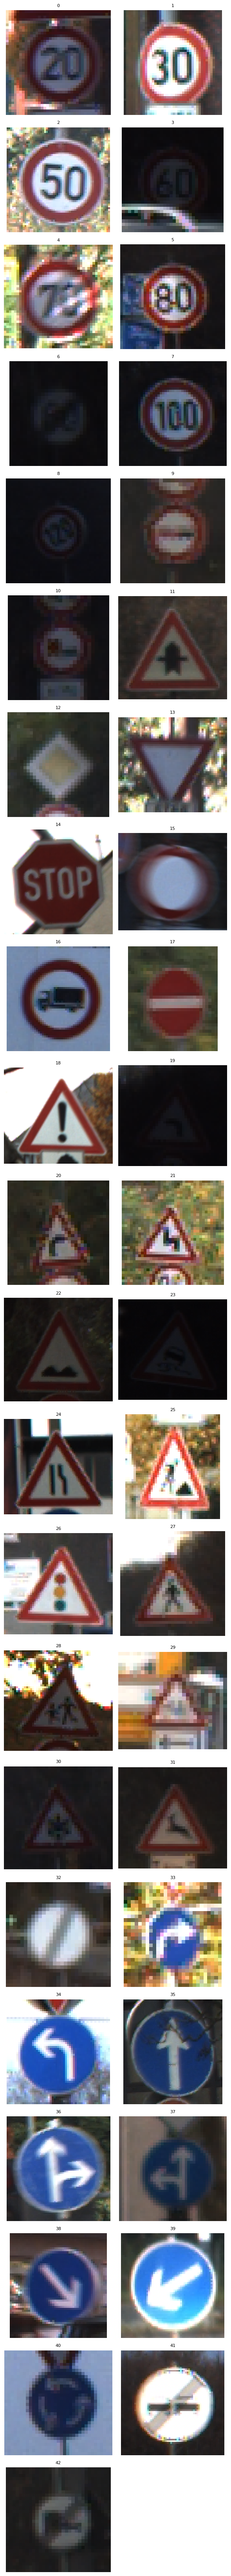

In [47]:
# Selecciona una imagen representativa por cada clase del conjunto de prueba
samples = test_df.groupby('ClassId').first().reset_index()

# Inicializa listas para guardar imágenes y etiquetas
sample_imgs = []
sample_labels = []

# Número de clases únicas
n_samples = len(samples)

# Itera por cada clase y carga la primera imagen correspondiente
for _, row in samples.iterrows():
    image = Image.open(f"{path}/{row['Path']}")  # Abre la imagen desde su ruta
    sample_labels.append(row['ClassId'])         # Guarda el ID de clase
    sample_imgs.append(image)                    # Guarda la imagen

# Muestra una imagen por clase en una cuadrícula vertical
utils.plot_images(images=sample_imgs, labels=sample_labels, nrows=round(n_samples/2), ncols=ncols, figsize=(6,66))


**Descripción de código**

Este bloque carga el dataset de entrenamiento GTSRB desde Test.csv, muestra estadísticas para entender la cantidad y variedad de datos, grafica la distribución de imágenes por clase (0 a 42) y visualiza una imagen representativa por clase. Esto permite detectar clases desbalanceadas y conocer visualmente las señales que el modelo debe aprender a clasificar.

# Image Shape

In [48]:
# Imprime el tamaño (ancho, alto) de la primera imagen en sample_imgs
print(f"Image shape: {sample_imgs[0].size}")

Image shape: (39, 39)


# Set X and Y variables

In [49]:
X = []  # Lista para las imágenes procesadas
y = []  # Lista para las etiquetas

# Itera sobre cada fila del DataFrame de entrenamiento
for index, row in train_df.iterrows():
    image_path = os.path.join(path, row["Path"])           # Construye la ruta de la imagen
    image = Image.open(image_path).resize((32, 32))        # Abre y redimensiona la imagen a 32x32
    X.append(np.array(image))                              # Convierte a array y lo guarda
    y.append(row["ClassId"])                               # Guarda la clase

X = np.array(X) / 255.0  # Normaliza los valores de píxel a [0, 1]
y = to_categorical(np.array(y), num_classes=43)  # Convierte etiquetas a one-hot encoding

# Muestra la forma final de X e y
print("X shape:", X.shape)  # Ej. (39209, 32, 32, 3)
print("y shape:", y.shape)  # Ej. (39209, 43)

X shape: (39209, 32, 32, 3)
y shape: (39209, 43)


**Descripción de código**

Este código carga todas las imágenes del dataset de entrenamiento, las redimensiona a 32x32 píxeles y normaliza sus valores. Además, convierte las etiquetas de clase a formato one-hot encoding para usarlas en una red neuronal. Al final, muestra las dimensiones del conjunto de datos procesado.

# Training, Validation and Testing dataset

In [50]:
# Divide los datos en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprime las formas de cada conjunto
print("X_train:", X_train.shape)  # Imágenes de entrenamiento
print("X_val:", X_val.shape)      # Imágenes de validación
print("y_train:", y_train.shape)  # Etiquetas de entrenamiento
print("y_val:", y_val.shape)      # Etiquetas de validación

X_train: (31367, 32, 32, 3)
X_val: (7842, 32, 32, 3)
y_train: (31367, 43)
y_val: (7842, 43)


**Descripción de código**

Este código divide el conjunto de datos en entrenamiento (80%) y validación (20%) de forma aleatoria pero reproducible. Luego imprime las dimensiones de cada subconjunto para verificar que la separación fue correcta.

In [51]:
X_test = []     # Lista para imágenes de prueba
y_test = []     # Lista para etiquetas
id_test = []    # Lista para las rutas relativas (útil para visualización)

# Itera sobre el conjunto de prueba y carga las imágenes
for index, row in test_df.iterrows():
    image_path = os.path.join(path, row["Path"])         # Ruta completa de la imagen
    image = Image.open(image_path).resize((32, 32))      # Redimensiona a 32x32
    X_test.append(np.array(image))                       # Guarda la imagen como array
    y_test.append(row["ClassId"])                        # Guarda la clase
    id_test.append(row["Path"])                          # Guarda la ruta para mostrarla después

X_test = np.array(X_test) / 255.0                        # Normaliza imágenes
y_test = to_categorical(np.array(y_test), num_classes=43)  # One-hot para 43 clases

# Muestra formas de los arreglos
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (12630, 32, 32, 3)
y_test shape: (12630, 43)


**Descripción de código**

Este bloque carga y preprocesa las imágenes del conjunto de prueba: las redimensiona a 32x32, normaliza los píxeles y convierte las etiquetas a one-hot encoding. Además, guarda las rutas para facilitar la visualización posterior y muestra las dimensiones finales de los datos procesados.

# CNN

## Model

In [52]:
model = Sequential()

# Bloque 1: 2 capas convolucionales + max pooling + dropout
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))  # Primera capa conv
model.add(Conv2D(32, (3, 3), activation='relu'))  # Segunda capa conv
model.add(MaxPooling2D(pool_size=(2, 2)))         # Reduce tamaño espacial
model.add(Dropout(0.25))                          # Previene sobreajuste

# Bloque 2: igual estructura, con más filtros
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Bloque 3: igual que el anterior
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Capas finales: clasificación
model.add(Flatten())                          # Aplana la salida
model.add(Dense(512, activation='relu'))      # Capa densa
model.add(Dropout(0.5))                       # Dropout extra
model.add(Dense(43, activation='softmax'))    # 43 clases (salida multiclase)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Descripción de código**

Define una red neuronal convolucional profunda para clasificar señales de tránsito (43 clases). Se compone de tres bloques de capas convolucionales con activación ReLU, seguidos de capas de MaxPooling y Dropout para reducir el sobreajuste. Al final, aplanamos las salidas y agregamos capas densas, incluida una capa final con activación softmax para la clasificación multiclase.

## Model compile

In [53]:
# Compila el modelo con el optimizador Adam, función de pérdida para clasificación multiclase y precisión como métrica
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Muestra el resumen del modelo: capas, parámetros y forma de salida
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,067 (1.12 MB)

 Trainable params: 293,067 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

## Model score

In [54]:
# Entrena el modelo durante 20 épocas con un batch size de 64
# Usa un conjunto de validación para evaluar el desempeño en cada época
history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.1719 - loss: 2.9965 - val_accuracy: 0.8273 - val_loss: 0.5584
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8237 - loss: 0.5408 - val_accuracy: 0.9699 - val_loss: 0.1108
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9412 - loss: 0.1974 - val_accuracy: 0.9878 - val_loss: 0.0475
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9621 - loss: 0.1239 - val_accuracy: 0.9883 - val_loss: 0.0453
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9715 - loss: 0.0961 - val_accuracy: 0.9911 - val_loss: 0.0328
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9776 - loss: 0.0773 - val_accuracy: 0.9912 - val_loss: 0.0287
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9795 - loss: 0.0685 - val_accuracy: 0.9948 - val_loss: 0.0187
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9824 - loss: 0.0554 - val_accuracy: 

In [55]:
# Evalúa el modelo con el conjunto de prueba
scores = model.evaluate(X_test, y_test, verbose=1)

# Muestra la pérdida y precisión en test
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9743 - loss: 0.1395
Test loss: 0.1349058449268341
Test accuracy: 0.9745843410491943


**Interpretación de resultado**

Test loss: 0.1395 → La pérdida del modelo es baja, lo que indica que las predicciones están cercanas a las verdaderas etiquetas.

Test accuracy: 0.9743 → El modelo acertó el 97.43 % de las predicciones en datos no vistos, lo que refleja una muy buena generalización.


**Descripción de código**

Este bloque compila, entrena y evalúa el modelo CNN para clasificación de señales:

* Compilación: Usa el optimizador Adam, pérdida categorical_crossentropy (adecuada para etiquetas one-hot) y precisión como métrica.

* Entrenamiento: Ejecuta 20 épocas con batch_size=64, evaluando el desempeño en el conjunto de validación (X_val, y_val) al final de cada época.

* Evaluación final: Calcula y muestra la pérdida y precisión del modelo en los datos de prueba (X_test, y_test). Esto permite medir qué tan bien generaliza el modelo a datos no vistos.

## Loss (Categorical Crossentropy)

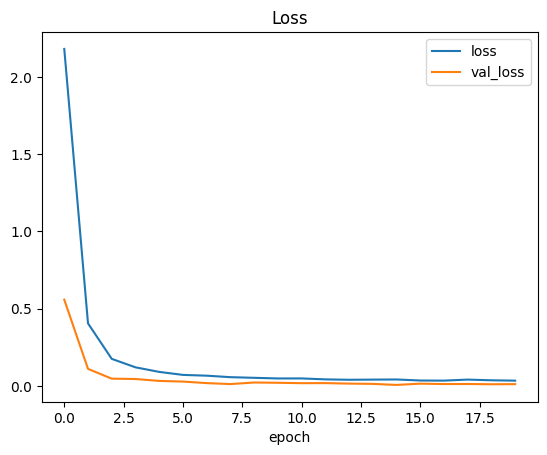

In [56]:
# Gráfica de la función de pérdida durante el entrenamiento
plt.plot(history.history['loss'])      # Pérdida en entrenamiento
plt.plot(history.history['val_loss'])  # Pérdida en validación
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

**Interpretación de resultado**

* Curva azul (loss): pérdida en el conjunto de entrenamiento y disminuye de forma constante, lo que indica que el modelo está aprendiendo correctamente.

* Curva naranja (val_loss): pérdida en el conjunto de validación y también disminuye, manteniéndose muy baja y estable.

La ausencia de separación significativa entre ambas curvas indica que no hay sobreajuste: el modelo generaliza bien a datos no vistos.


## Accuracy

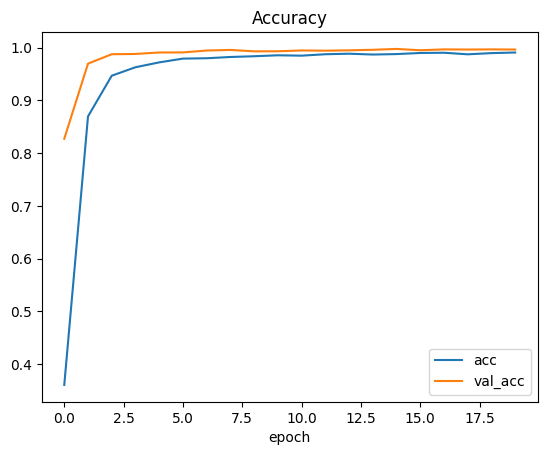

In [57]:
# Gráfica de precisión durante el entrenamiento
plt.plot(history.history['accuracy'])        # Precisión en entrenamiento
plt.plot(history.history['val_accuracy'])    # Precisión en validación
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

**Interpretación de resultado**

* Línea azul (acc): precisión en el conjunto de entrenamiento, que aumenta rápidamente y se estabiliza cerca de 0.99.

* Línea naranja (val_acc): precisión en el conjunto de validación, que se mantiene muy alta desde el inicio (mayor a 0.97).

Ambas curvas son altas y estables, sin señales de sobreajuste ni caídas bruscas.


## Model prediction

In [58]:
# Diccionario de nombres de clases GTSRB
id_to_name = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)", 3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)", 6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)", 9: "No passing", 10: "No passing for vehicles > 3.5 tons", 11: "Right-of-way at intersection",
    12: "Priority road", 13: "Yield", 14: "Stop", 15: "No vehicles", 16: "Vehicles > 3.5 tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve left", 20: "Dangerous curve right",
    21: "Double curve", 22: "Bumpy road", 23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing", 29: "Bicycles crossing",
    30: "Beware of ice/snow", 31: "Wild animals crossing", 32: "End of all restrictions", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right", 37: "Go straight or left",
    38: "Keep right", 39: "Keep left", 40: "Roundabout mandatory", 41: "End of no passing", 42: "End of no passing >3.5t"
}

# Imprimir todas las clases en orden
print("Lista de clases GTSRB (ID: Nombre de la señal):\n")
for i in range(43):
    print(f"{i:2d}: {id_to_name[i]}")

Lista de clases GTSRB (ID: Nombre de la señal):

 0: Speed limit (20km/h)
 1: Speed limit (30km/h)
 2: Speed limit (50km/h)
 3: Speed limit (60km/h)
 4: Speed limit (70km/h)
 5: Speed limit (80km/h)
 6: End of speed limit (80km/h)
 7: Speed limit (100km/h)
 8: Speed limit (120km/h)
 9: No passing
10: No passing for vehicles > 3.5 tons
11: Right-of-way at intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles > 3.5 tons prohibited
17: No entry
18: General caution
19: Dangerous curve left
20: Dangerous curve right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all restrictions
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing >3.5

In [59]:
# Obtener clase predicha y verdadera
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión y reporte
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       0.99      1.00      1.00       750
           3       0.98      0.94      0.96       450
           4       1.00      1.00      1.00       660
           5       0.95      0.99      0.97       630
           6       1.00      0.86      0.92       150
           7       0.98      1.00      0.99       450
           8       1.00      0.96      0.98       450
           9       0.92      1.00      0.96       480
          10       0.99      1.00      0.99       660
          11       0.98      1.00      0.99       420
          12       1.00      0.94      0.97       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       1.00      1.00      1

**Interpertación de resultados**
* El modelo alcanza una precisión general del 97 %, con un F1-score promedio de 0.96, lo que indica un excelente desempeño en el conjunto de prueba.

* Las clases con más ejemplos (como la 2, 13 y 38) tienen resultados casi perfectos, mientras que algunas clases menos representadas (como la 20 y 41) muestran menor recall o precisión.

* Aunque el rendimiento global es alto, hay margen de mejora en clases con soporte bajo.


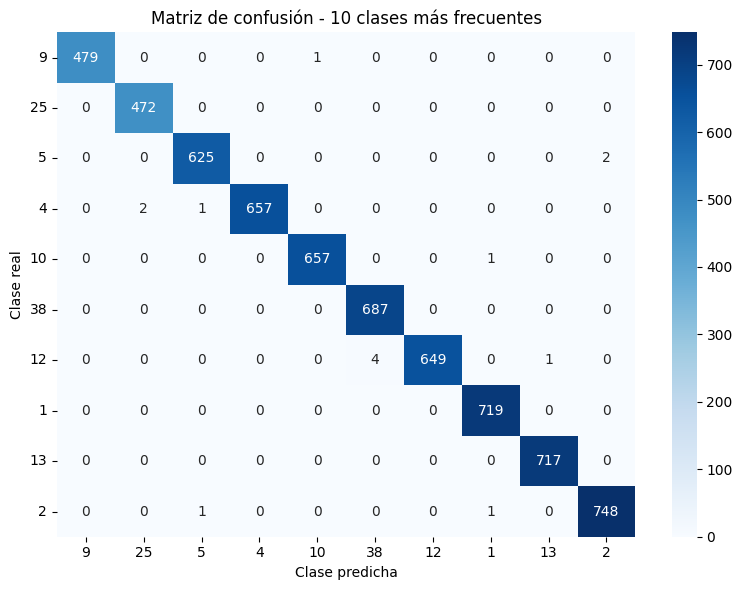

In [60]:
# Obtener las 10 clases más frecuentes en el test set
top_classes = np.argsort(np.bincount(y_true))[-10:]

# Filtrar la submatriz de confusión para esas clases
cm_top = cm[np.ix_(top_classes, top_classes)]

# Graficar heatmap con mejor visibilidad
plt.figure(figsize=(8, 6))  # Aumentar tamaño de la figura
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_classes, yticklabels=top_classes)

plt.title("Matriz de confusión - 10 clases más frecuentes")
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpertación de resultados**
* El modelo tiene un desempeño muy alto en las 10 clases más frecuentes, con la mayoría de las predicciones correctamente ubicadas en la diagonal.

* Clases como la 2, 13, 1 y 38 muestran una precisión casi perfecta, con más de 660 aciertos cada una.

* Se observan pocos errores, siendo los más notables en las clases 4 y 5, donde hay ligeras confusiones con otras señales similares.

**Descripción de código**

Evalúa el modelo en el conjunto de prueba. Imprime los nombres de las clases, obtiene las predicciones, genera un reporte de clasificación y una matriz de confusión. Luego, selecciona las 10 clases más frecuentes y muestra un heatmap para visualizar los aciertos y errores más comunes del modelo.










In [61]:
# Genera rutas completas de las imágenes de prueba
image_paths_test = [os.path.join(path, img_path) for img_path in id_test]

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


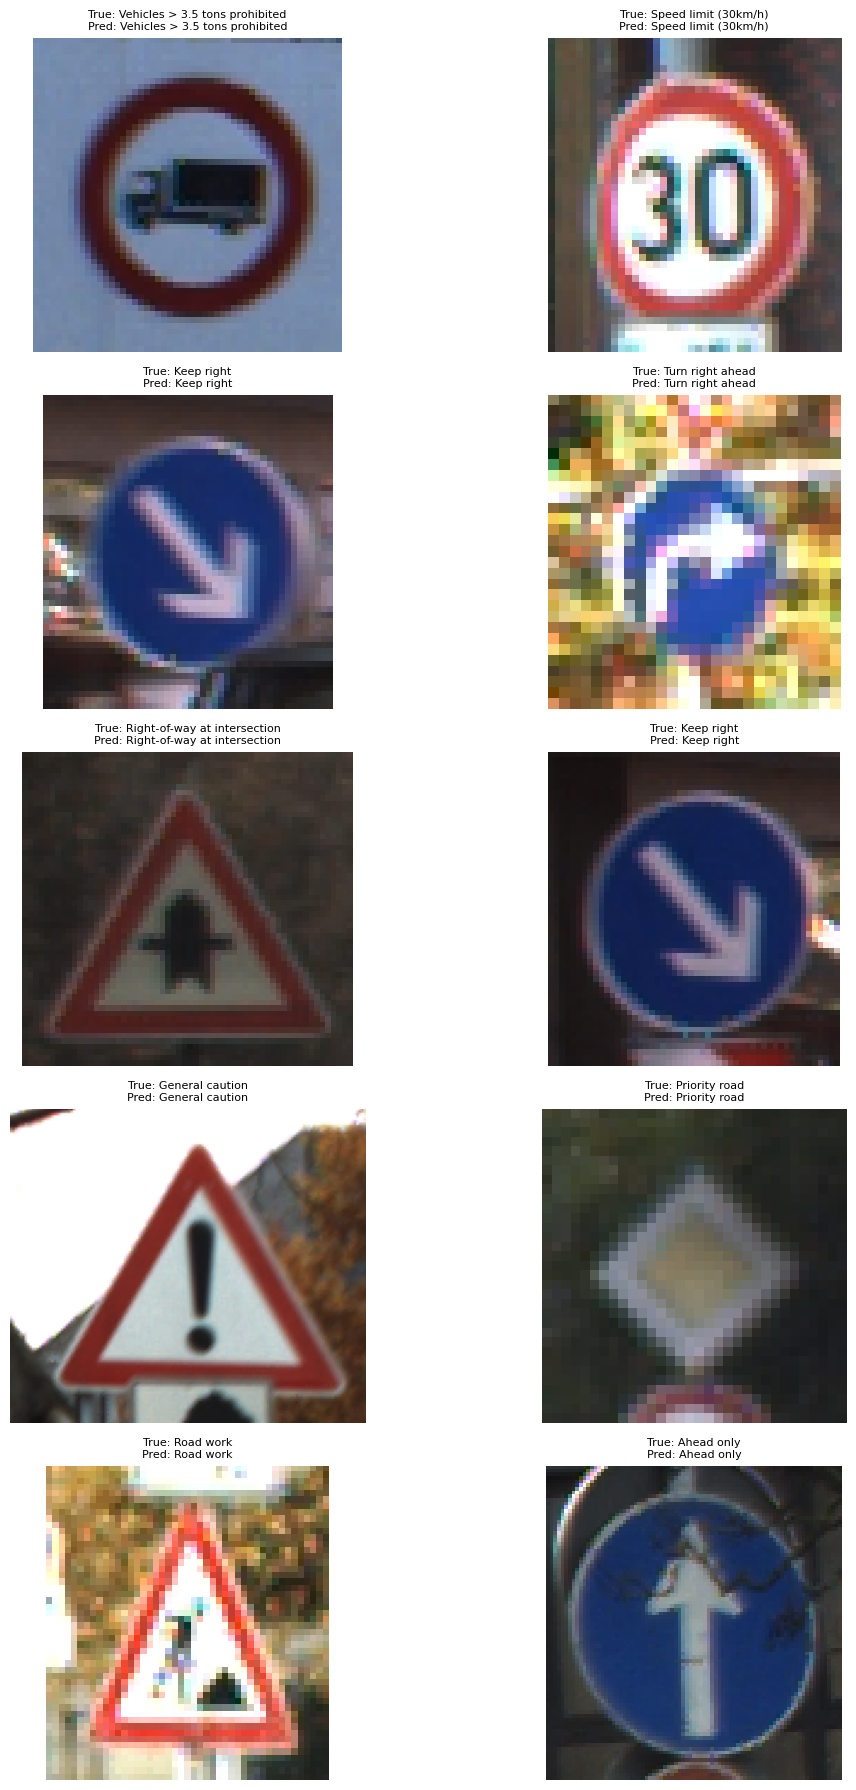

In [62]:
pred_probs = model.predict(X_test)                         # Probabilidades predichas para cada clase
pred_classes = np.argmax(pred_probs, axis=1)               # Clase predicha (con mayor probabilidad)
y_true = np.argmax(y_test, axis=1)                         # Clase real a partir de one-hot

# Mostrar imágenes con sus predicciones y etiquetas reales
utils.show_predictions(
    image_ids=image_paths_test,
    y_true=y_true,
    y_pred=pred_classes,
    nrows=nrows,
    ncols=ncols,
    figsize=figsize
)

**Interpertación de resultados**
* En todas las imágenes mostradas, la predicción coincide con la etiqueta real, lo que indica que el modelo fue capaz de reconocer correctamente distintos tipos de señales de tránsito.

* Las señales incluyen tanto prohibiciones (ej. “Vehicles > 3.5 tons prohibited”), como indicaciones (ej. “Keep right”) y advertencias (ej. “General caution” o “Road work”).

* Este resultado confirma que el modelo predice bien clases frecuentes y generaliza correctamente a distintas categorías visuales.

**Descripción de código**

Genera las rutas completas de las imágenes de prueba, obtiene las predicciones del modelo, las compara con las clases reales y finalmente muestra una cuadrícula de imágenes con sus etiquetas verdaderas y predichas usando utils.show_predictions. Sirve para evaluar visualmente el desempeño del modelo.







